jupyter kernelspec list

In [4]:
import pandas as pd
import numpy as np
weights = {'D2_Macula': 1, 'D50_Lens': 1}


In [6]:
df = pd.read_csv('results/eval_history.csv', header = [0,1])
df.head()

Unnamed: 0_level_0 gaze_angles             dvh_points                  \
  Unnamed: 0_level_1       polar azimuthal    D2_Macula D20_OpticalDisc   
0                  0         0.0       0.0  5760.626465     3957.569336   
1                  1        25.0       0.0  5587.671875     4933.803711   
2                  2        25.0      51.4  5939.323242     5869.455566   
3                  3        25.0     102.9  5978.158203     5532.302734   
4                  4        25.0     154.3  5975.160156     3931.896973   

                                                                            \
    D20_Cornea V55_Retina V27_CiliaryBody      D5_Lens dose_volume_penalty   
0  3565.484375   0.080679        0.286520  3980.339844           98.106642   
1    35.668846   0.086630        0.249888  3811.048096           94.891984   
2     0.000000   0.134706        0.154100   343.298004          117.025311   
3     0.000000   0.139024        0.111709    27.726879          111.387675   
4     0.000000   0.131512        0.166363   733.113953           93.506555   

     total_cost   Unnamed: 0_level_0  
           cost Unnamed: 0_level_1.1  
0  36798.885462                  0.0  
1  35506.372203                  0.0  
2  35886.948548                  0.0  
3  34670.748100                  0.0  
4  30548.089770                  0.0

In [39]:
def get_row_by_gaze(df, a, b):
    h1 = ('gaze_angles', 'polar')
    h2 = ('gaze_angles', 'azimuthal')
    mask = (df[h1] == a) & (df[h2] == b)
    return df[mask]
get_row_by_gaze(df, polar, azimuthal)

Unnamed: 0_level_0 gaze_angles             dvh_points                  \
  Unnamed: 0_level_1       polar azimuthal    D2_Macula D20_OpticalDisc   
4                  0        25.0     154.3  5975.160156     3931.896973   

                                                                         \
  D20_Cornea V55_Retina V27_CiliaryBody     D5_Lens dose_volume_penalty   
4        0.0   0.131512        0.166363  733.113953           93.506555   

    total_cost  
          cost  
4  30548.08977

In [11]:
idx_min = df[('dvh_points', 'D2_Macula')].idxmin()
polar = df.loc[idx_min, ('gaze_angles', 'polar')]
azimuthal = df.loc[idx_min, ('gaze_angles', 'azimuthal')]
polar, azimuthal

(25.0, 308.6)

In [17]:
a = {'a': 1, 'b': 10}
max(a.values())

10

In [22]:
import matplotlib.pyplot as plt
import numpy as np

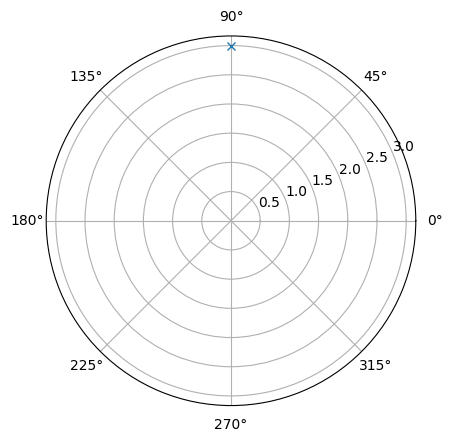

In [24]:
plt.subplot(111, polar=True)
plt.plot(np.pi/2, 3, 'x')
plt.show()

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
a = np.array([1, 10, 2, 3])
np.cumsum(a)

array([ 1, 11, 13, 16])

In [55]:
import h5py

def print_hdf5_structure(file_path):
    """
    Recursively prints the structure of an HDF5 file, including groups, datasets, and attributes.
    
    Parameters
    ----------
    file_path : str
        Path to the HDF5 file.
    """

    def print_attrs(name, obj, indent=0):
        """Helper to print attributes of a group or dataset."""
        prefix = " " * indent
        if obj.attrs:
            print(f"{prefix}  Attributes:")
            for key, val in obj.attrs.items():
                print(f"{prefix}    - {key}: {val}")

    def print_group(name, obj, indent=0):
        """Recursive visitor function for groups and datasets."""
        prefix = " " * indent
        if isinstance(obj, h5py.Group):
            print(f"{prefix}Group: {name}/")
        elif isinstance(obj, h5py.Dataset):
            print(f"{prefix}Dataset: {name} | shape={obj.shape}, dtype={obj.dtype}")
        print_attrs(name, obj, indent)

    # Open and walk through the file
    with h5py.File(file_path, "r") as f:
        print(f"HDF5 File: {file_path}")
        f.visititems(lambda name, obj: print_group(name, obj, indent=len(name.split('/')) * 2))

# Example usage:
print_hdf5_structure('results/17213.h5')


HDF5 File: results/17213.h5
  Group: gaze_angles/
    Group: gaze_angles/0_0/
      Attributes:
        - D20_Cornea: 60.983740234375
        - D20_OpticalDisc: 0.32911693572998046
        - D2_Macula: 4.1101596069335935
        - D5_Lens: 60.5395068359375
        - V27_CiliaryBody: 52.38054915659836
        - V55_Retina: 40.62586054555284
        - gaze_angle: [0 0]
        - total_cost: 427.56380320335427
        - volume_term: 199.71631680289985
      Dataset: gaze_angles/0_0/Chamber | shape=(100,), dtype=float64
      Dataset: gaze_angles/0_0/CiliaryBody | shape=(100,), dtype=float64
      Dataset: gaze_angles/0_0/Clip_m1 | shape=(100,), dtype=float64
      Dataset: gaze_angles/0_0/Clip_m2 | shape=(100,), dtype=float64
      Dataset: gaze_angles/0_0/Clip_m3 | shape=(100,), dtype=float64
      Dataset: gaze_angles/0_0/Clip_m4 | shape=(100,), dtype=float64
      Dataset: gaze_angles/0_0/Clip_m5 | shape=(100,), dtype=float64
      Dataset: gaze_angles/0_0/Cornea | shape=(100,), dtype=

In [ ]:
with h5py.File('results/test.h5', "r") as f:
    roi = 'OpticalNerve'
]
    gaze_angles = f['gaze_angles']['']

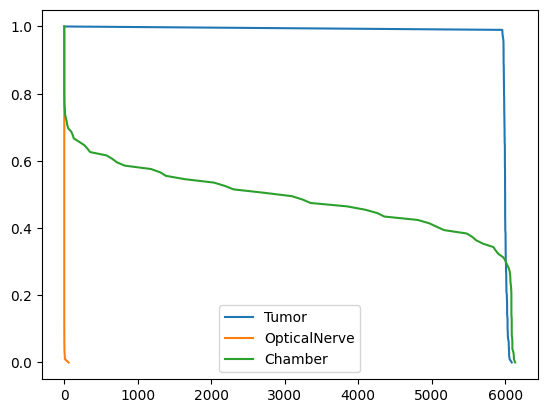

In [2]:
with h5py.File('results/test.h5', "r") as f:
    rois = ['Tumor', 'OpticalNerve', 'Chamber']
    for roi in rois:
        dvh_roi = f['gaze_angles']['(0, 0)'][roi][:]
        #print(dvh_roi)
        plt.plot(dvh_roi,np.linspace(0, 1, 100), label=roi);
    plt.legend()
    plt.show()


In [53]:
angle_key = '25_110'
with h5py.File('results/test.h5', "r") as f:
    print(f['gaze_angles'][angle_key].attrs['volume_term'])

350.3725843601816


In [28]:
tuple(a)

(0, 0)